# Coffee Data Notebook

Looking at different aspects of the data, mostly to improve collection and have more awareness.


In [1]:
import os
import math

from collections import defaultdict
from tempfile import NamedTemporaryFile

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [2]:
# Modifiy this to point at the directory where all of the images live.
DATA_DIR = os.path.expanduser("~/coffee-images/")
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"
plt.rcParams["figure.dpi"] = 150

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)

### Data Distribution

The following graph presents the number of images associated with each pull time. Useful to determine where more data needs to be collected.

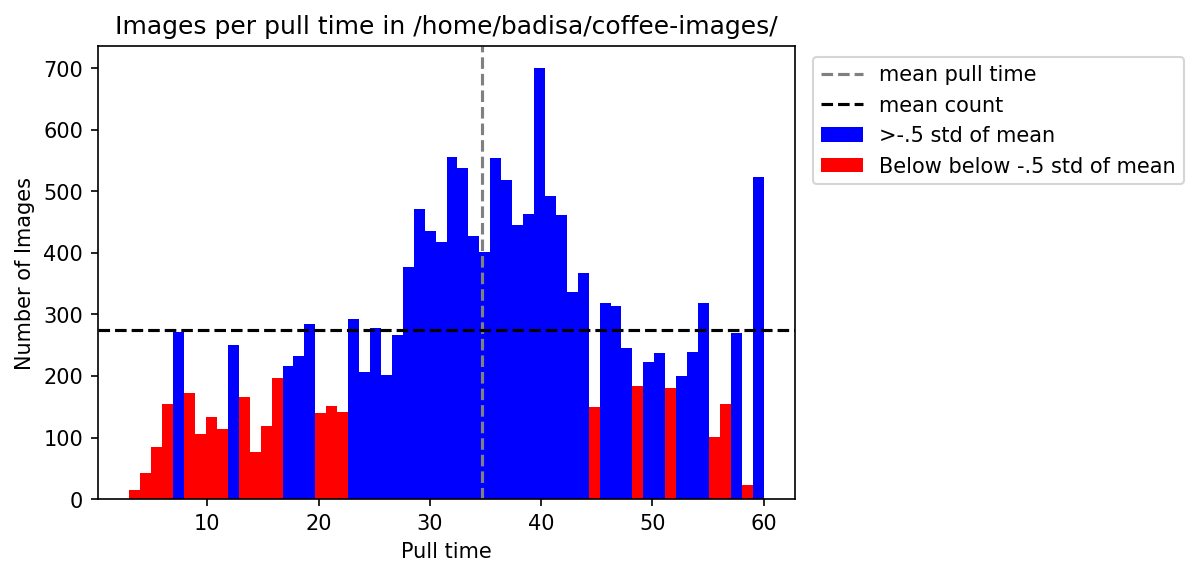

21 pull times which could do with more data
Lowest 10 pull times
3
59
4
14
5
56
9
11
15
10


In [3]:
counts = []
for key, val in images_by_time.items():
    counts.append((key, len(val)))
mean_count = np.mean([x[1] for x in counts])
std_count = np.std([x[1] for x in counts])
counts.sort(key=lambda x: x[1])
lowest = [x[0] for x in counts if x[1] < mean_count - std_count * .5]
good_hist_data = []
low_hist_data = []
for key, val in images_by_time.items():
    if key in lowest:
        for _ in range(len(val)):
            low_hist_data.append(key)
    else:
        for _ in range(len(val)):
            good_hist_data.append(key)
#     print(f"{time}s {count} images")
plt.hist(
    [good_hist_data, low_hist_data],
    len(images_by_time),
    color=["blue", "red"],
    stacked=True,
    label=[">-.5 std of mean", "Below below -.5 std of mean"]
)
plt.xlabel("Pull time")
plt.ylabel("Number of Images")
plt.title(f"Images per pull time in {DATA_DIR}")
plt.axvline(np.mean(good_hist_data + low_hist_data), label="mean pull time", linestyle="--", color="gray")
plt.axhline(mean_count, label="mean count", linestyle="--", color="black")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()
print(len(lowest), "pull times which could do with more data")
print("Lowest 10 pull times")
for low in lowest[:10]:
    print(low)

### Grinder/Pull Variation

The following looks at the variation seen in shot pull times at the same grind setting. Assumes a normal distribution of the shot times, which has yet to be confirmed.

Only evaluate in cases where there are between 5 and 20 shots. Until there is a decent way to partition the shots by time/batch, it seems unreasonable to evaluate larger batches.

In [4]:
# Download CSV, won't work on windozes
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
# Clean up the CSV file.
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
# Only care about data that has a grinder associated
invalid_indices = df[(df["grinder"] == "None") | (df["details"].str.contains("prediction"))].index

df.drop(invalid_indices, inplace=True)
date = pd.to_datetime(df.date, infer_datetime_format=True, utc=True)
roastdate = pd.to_datetime(df.roastdate, infer_datetime_format=True, utc=True)
df = df.assign(days_off_roast = date - roastdate)
df["roastdate"] = df["roastdate"].astype(str).replace("nan", "")

Fit func  
0.04993 x + 0.8425


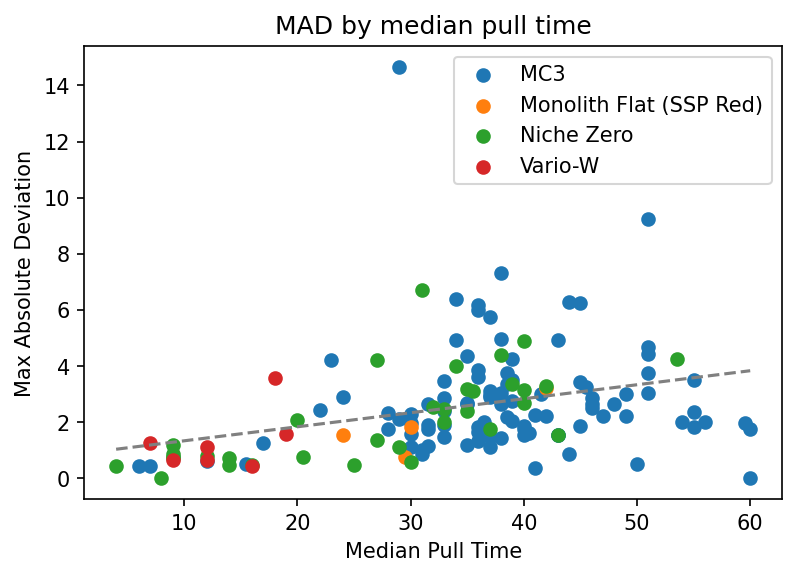

Fit func  
0.05652 x + 0.6099


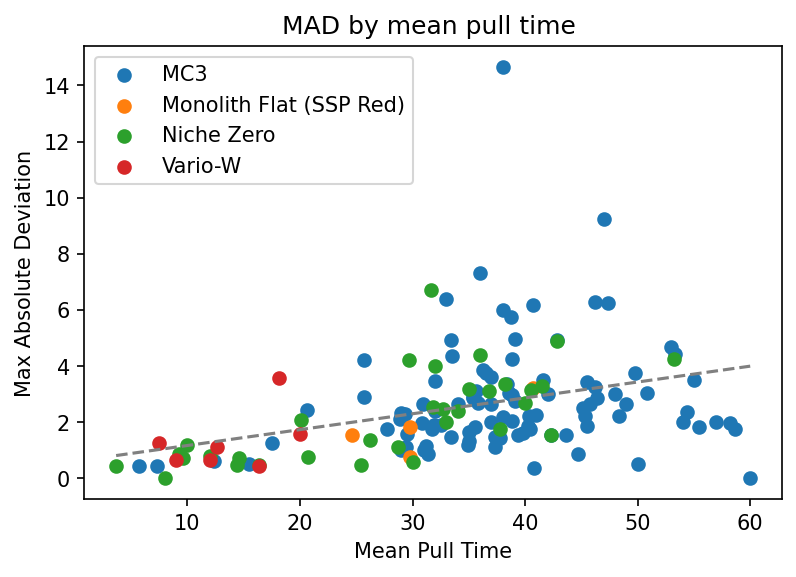

In [5]:
groupby = ["grinder", "grindersetting", "coffee", "roastdate"]
grouped = df.groupby(groupby, dropna=False)

def filter_func(x):
    # Filter out things that don't have a roast date and more than 20 shots or less than 3
    if len(x) < 3:
        return False
    roastdate = x.roastdate.unique()
    if len(roastdate) == 1 and roastdate[0] == "":
        if len(x) < 20:
            return True
        return False
    return True

grouped = grouped.filter(filter_func).groupby(groupby, dropna=False)
df_med = grouped.median()
df_mad = grouped.mad()
x = defaultdict(list)
y = defaultdict(list)
for indice in df_mad.index:
    if indice not in df_med.index:
        continue
    if math.isnan(df_med.time[indice]) or math.isnan(df_mad.time[indice]):
        continue
    grinder = indice[0]
    x[grinder].append(df_med.time[indice])
    y[grinder].append(df_mad.time[indice])
all_x = []
all_y = []
for grinder in x.keys():
    all_x.extend(x[grinder])
    all_y.extend(y[grinder])
    plt.scatter(x[grinder], y[grinder], label=grinder)
poly_fit = np.poly1d(np.polyfit(all_x, all_y, 1))
print("Fit func", poly_fit)
plt.plot(
    np.unique(all_x),
    poly_fit(np.unique(all_x)),
    color="gray",
    linestyle="--",
)
plt.xlabel("Median Pull Time")
plt.ylabel("Max Absolute Deviation")
plt.title("MAD by median pull time")
plt.legend()
plt.show()

df_mean = grouped.mean()
x = defaultdict(list)
y = defaultdict(list)
for indice in df_mean.index:
    if indice not in df_mad.index:
        continue
    grinder = indice[0]
    if math.isnan(df_mean.time[indice]) or math.isnan(df_mad.time[indice]):
        continue
    x[grinder].append(df_mean.time[indice])
    y[grinder].append(df_mad.time[indice])
all_x = []
all_y = []
for grinder in x.keys():
    all_x.extend(x[grinder])
    all_y.extend(y[grinder])
    plt.scatter(x[grinder], y[grinder], label=grinder)
poly_fit = np.poly1d(np.polyfit(all_x, all_y, 1))
print("Fit func", poly_fit)
plt.plot(
    np.unique(all_x),
    poly_fit(np.unique(all_x)),
    color="gray",
    linestyle="--",
)
plt.xlabel("Mean Pull Time")
plt.ylabel("Max Absolute Deviation")
plt.title("MAD by mean pull time ")
plt.legend()
plt.show()

/home/badisa/miniconda3/envs/optpresso/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


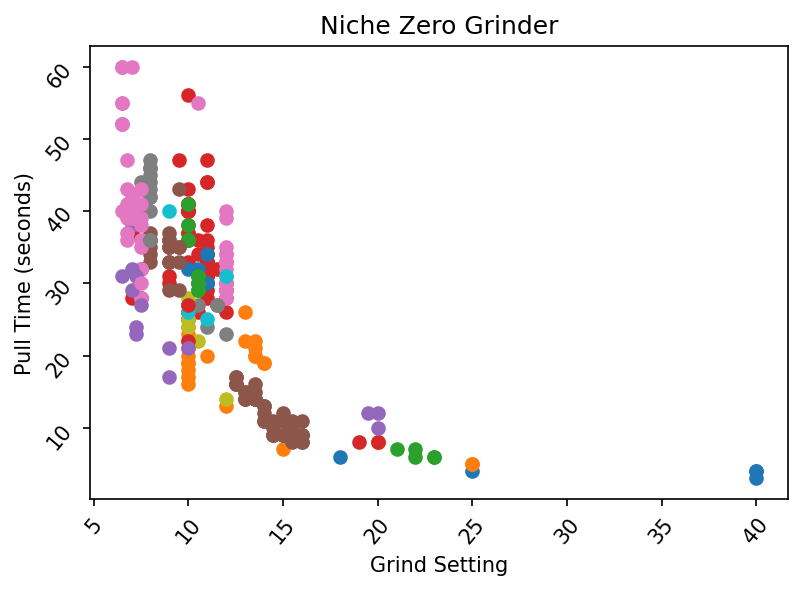

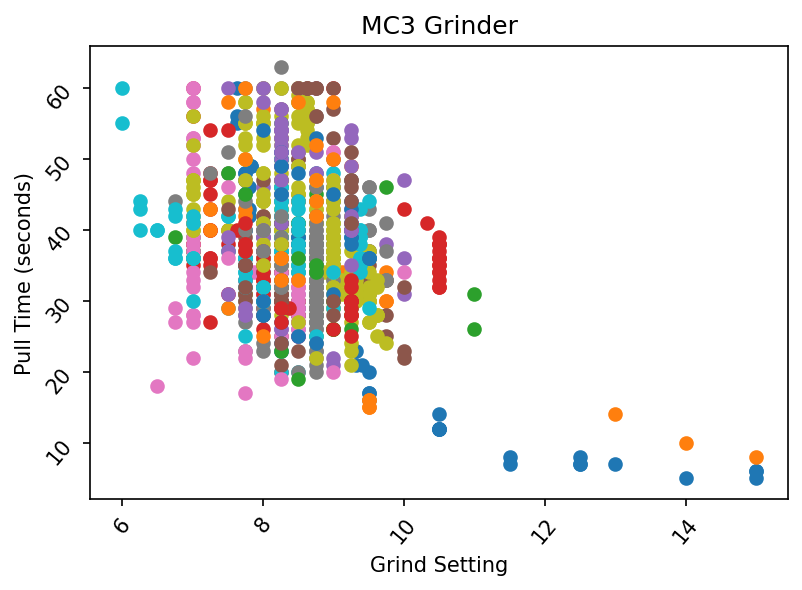

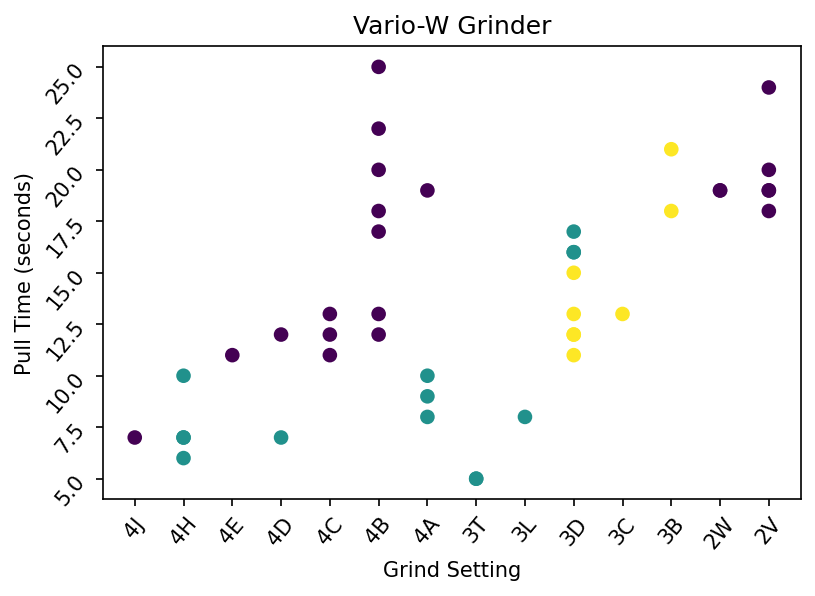

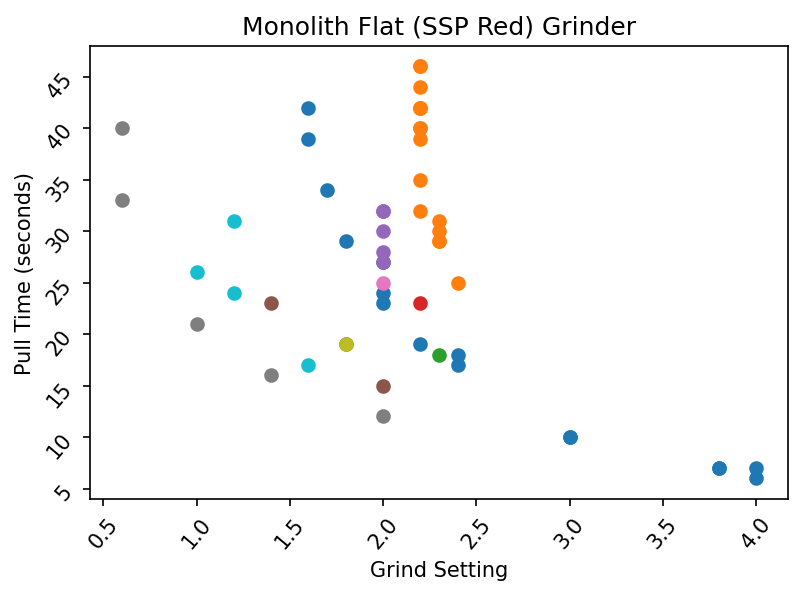

In [6]:
for grinder in df.grinder.unique():
    if grinder == "None":
        continue
    fig = plt.Figure()
    axe = fig.gca()
    subdf = df[df["grinder"] == grinder]
    # Sort the list initially
    try:
        subdf.loc[:, ("grindersetting",)] = pd.to_numeric(subdf.grindersetting)
        subdf = subdf.sort_values("grindersetting", ascending=False)
        for coffee in subdf.coffee.unique():
            coffeedf = subdf[subdf.coffee == coffee]
            axe.scatter(coffeedf.grindersetting, coffeedf.time)
    except Exception as e:
        # To get meaningful ordering on the y axis, have to scatter in one pass.
        # Could also move to using numeric y axis values and replacing the labels with
        # the corresponding labels.
        subdf = subdf.sort_values("grindersetting", ascending=False)
        colors = np.zeros_like(subdf.grindersetting.values)
        for i, coffee in enumerate(subdf.coffee.unique()):
            colors[np.argwhere(subdf.coffee.values == coffee)] = i +1
        axe.scatter(subdf.grindersetting, subdf.time, c=colors)
#     axe.plot(subdf.grindersetting.unique(), np.polyfit(subdf.grindersetting, subdf.time, 1)(subdf.grindersetting.unique()))
    axe.set_title(f"{grinder} Grinder")
    axe.set_xlabel("Grind Setting")
    axe.set_ylabel("Pull Time (seconds)")
    axe.tick_params(labelrotation=50)
    display(fig)

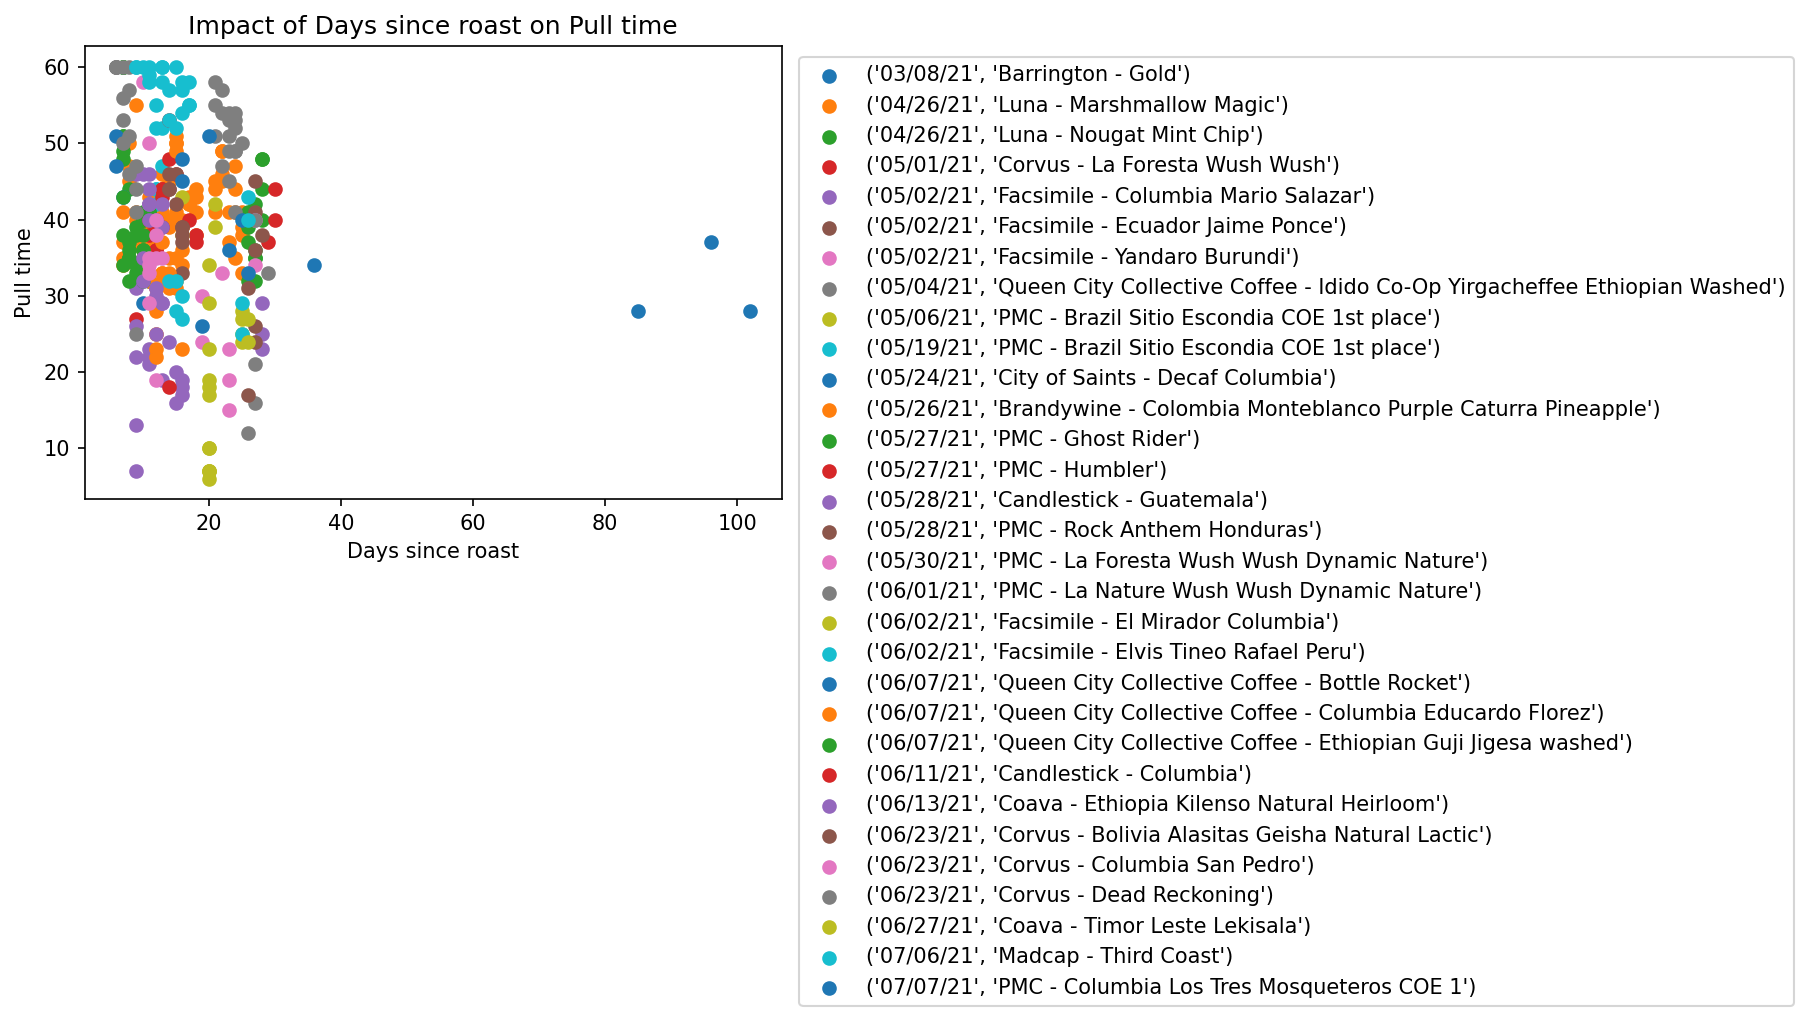

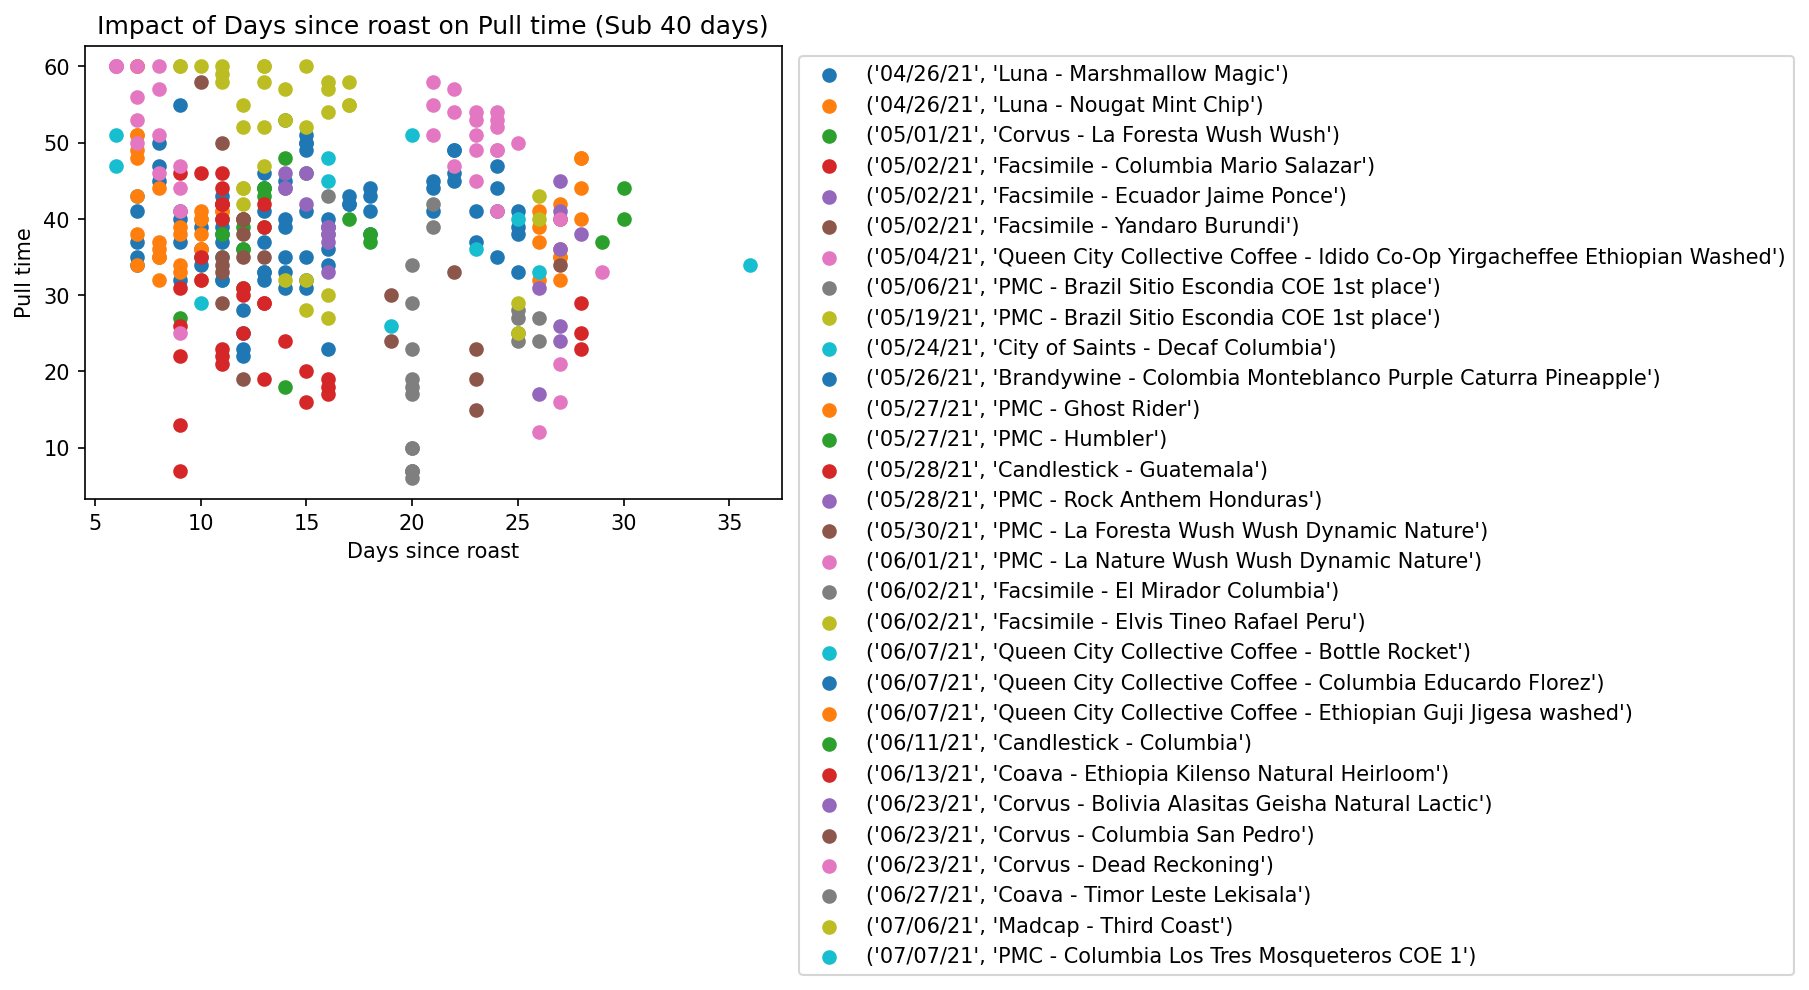

In [7]:
offroast_df = df[df["days_off_roast"].notna()]
for name, subdf in offroast_df.groupby(["roastdate", "coffee"]):
    plt.scatter(
        subdf.days_off_roast.astype("timedelta64[D]"),
        subdf.time,
        label=name
    )
plt.title("Impact of Days since roast on Pull time")
plt.xlabel("Days since roast")
plt.ylabel("Pull time")
plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

for name, subdf in offroast_df.groupby(["roastdate", "coffee"]):
    days_off_roast = subdf.days_off_roast.astype("timedelta64[D]")
    if np.any(days_off_roast > 40):
        continue
    plt.scatter(
        days_off_roast,
        subdf.time,
        label=name
    )
plt.title("Impact of Days since roast on Pull time (Sub 40 days)")
plt.xlabel("Days since roast")
plt.ylabel("Pull time")
plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

